## American sign language detection with WediaPipe, TensorFlow, and Inceptionv3

## Introduction

The ability of a system to perceive and detect sign language is a vital component of improving accessibility across a variety of technological domains and platforms. For example, it can understand sign language and hand gestures and overlay the translation on top of the physical world in augmented or virtual reality. The real-time hand gesture perception has been solved by Google's MediaPipe and open-source, cross-platform framework for building pipelines to process data of different natures such as video and audio. The MediaPipe hand landmarks detection approach allows us to detect the position of individual fingers, making it ideal for building a machine learning model to identify sign language numbers and alphabet.



#### Reference:

MediaPipe: https://mediapipe.dev/

Tensorflow: https://www.tensorflow.org/

Keras: https://www.tensorflow.org/api_docs/python/tf/keras

Inceptionv3: https://keras.io/api/applications/inceptionv3/


#### Technical concepts

Computer Vision, 
TensorFlow,
Keras,
MediaPipe, I
nceptionV3, 
Convolutional Neural Network (CNN)

#### Project Steps:

Step 1: Collect image datasets of American Sign Language.

Step 2: Process the image dataset with MediaPipe to detect hand landmarks and features such as fingers and palm.

Step 3: Prepare the new image dataset for training using Keras Image Data Generator.

Step 4: Build the machine learning model using Google's Inceptionv3 as a baseline to take advantage of transfer learning.

Step 4: Use the model to predict unseen hand sign images.

Step 5: Use the Model to build a live hand sign transcription.

## Loading the image dataset & Data Preparation

We build an image dataset by combing sign language datasets from the following sources.

https://www.kaggle.com/datasets/kapillondhe/american-sign-language

https://www.kaggle.com/datasets/kuzivakwashe/significant-asl-sign-language-alphabet-dataset

https://www.kaggle.com/datasets/ayuraj/asl-dataset

Each hand sign has a folder labeled with the hand sign containing several images of unique hands performing the sign language in the root folders.

In [26]:
# importing necessary libraries
import os
import cv2
import mediapipe as mp

# Loading MediaPipe Modules
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands


In [27]:
# dataset location directory
asl_data_dir = "datasets/combine_asl_dataset"

# New directory for processed images
processed_data_dir = "datasets/processed_combine_asl_dataset_3d"

# Get subfolders
subfolders = os.listdir(asl_data_dir)

# Image size
target_size = (400, 400)

# Background image to draw hand landmarks on
background_img = cv2.imread("background_black.png")




#### Generating the new dataset with MediaPipe

Next, using MediaPipe, we navigate the image dataset and generate new images of each hand sign. The generated image represents the hand landmark position, such as the thumb or index finger position.

In [ ]:
for folder in subfolders:
    # Path to images
    img_path = asl_data_dir + "/" + folder
    # Get all images in the directory
    IMAGE_FILES = os.listdir(img_path)
    # Create folder to save the processed images
    proc_path = processed_data_dir + "/" + folder
    try: 
        os.mkdir(proc_path) 
    except OSError as error: 
        print(error)
    
    # Detect hand landmarks in images
    with mp_hands.Hands(
        static_image_mode=True,
        # Detecting one hand only
        max_num_hands=2,
        model_complexity=1,
        min_detection_confidence=0.4) as hands:
            for idx, file in enumerate(IMAGE_FILES):
                # Read an image, flip it around y-axis for correct handedness
                image = cv2.flip(cv2.imread(img_path + "/" + file), 1)
                #image = Image.load_img(img_path + "/" + file)
                # Resize the image
                #image = Image.smart_resize(image, target_size)
                #image = Image.array_to_img(image)
            
                # Convert the BGR image to RGB before processing.
                results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                #results = hands.process(image)

                # Print handedness and draw hand landmarks on the background image.
                #print('Handedness:', results.multi_handedness)
                if not results.multi_hand_landmarks:
                    continue
                # Image dimensions
                image_height, image_width, image_channel = image.shape
                target_size = (image_height, image_width)
                annotated_image = cv2.resize(background_img.copy(), target_size)

                for hand_landmarks in results.multi_hand_landmarks:
                    #print('hand_landmarks:', hand_landmarks)
                    
                    mp_drawing.draw_landmarks(
                        annotated_image,
                        hand_landmarks,
                        mp_hands.HAND_CONNECTIONS,
                        mp_drawing_styles.get_default_hand_landmarks_style(),
                        mp_drawing_styles.get_default_hand_connections_style()
                    )
                #Save the processed image
                cv2.imwrite(proc_path + "/" + file, cv2.flip(annotated_image, 1))

                #Draw hand world landmarks.
                # if not results.multi_hand_world_landmarks:
                #     continue
                # for hand_world_landmarks in results.multi_hand_world_landmarks:
                #     mp_drawing.plot_landmarks(
                #         hand_world_landmarks, 
                #         mp_hands.HAND_CONNECTIONS, 
                    
                #         azimuth = 5
                #     )

                # Save the processed image
                #cv2.imwrite(proc_path + "/" + file, cv2.flip(annotated_image, 1))

#### Processing the new dataset for training with Keras Image Data Generator

In total, we have 105420 files belonging to 36 classes. Each class represents a hand sign.
We have 73809 images for training and 31611 images for validation.

In [ ]:
# Importing necessary libraries
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
processed_data_dir = "datasets/processed_combine_asl_dataset"
# dataset generation
asl_data = tf.keras.preprocessing.image_dataset_from_directory(processed_data_dir)


Found 105420 files belonging to 36 classes.


In [29]:
# Define arguments for the Model
height = 300
width = 300
channels = 3
batch_size = 512
target_shape = (height, width, channels)
target_size = (height, width)
num_classes = len(asl_data.class_names)

In [ ]:
# Data generator argument; 30% of the data used for validation
datagen_args = dict(
        rescale = 1./300,  
        width_shift_range = 1.0,
        height_shift_range = 1.0,
        shear_range = 0.5,
        zoom_range = 0.3,
        horizontal_flip = True,
        validation_split = 0.30
)

# Data generator object
datagen = ImageDataGenerator(**datagen_args)

# Split Training and validation setting
train_generator = datagen.flow_from_directory(
    processed_data_dir,
    target_size = target_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True,
    subset = 'training'
)

validation_generator = datagen.flow_from_directory(
    processed_data_dir,
    target_size = target_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True,
    subset = 'validation'
)

Found 73809 images belonging to 36 classes.
Found 31611 images belonging to 36 classes.


#### Data Exploration
Here we take a look at a few of our generated images.

In [17]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
# Function to display images
plt.figure(figsize=(15, 20))
def display_img(dataset):
    for images, labels in dataset.take(1):
        for i in range(10):
            ax = plt.subplot(4, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(asl_data.class_names[labels[i]])
            plt.axis("off")

<Figure size 1440x1440 with 0 Axes>

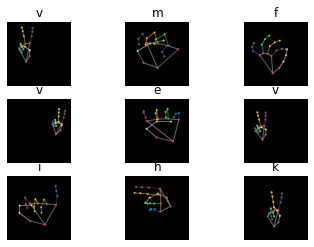

In [43]:
# Displaying the images in the dataset
display_img(asl_data)

## Building the Machine Learning Model

We will use transfer learning, a pre-trained model on our dataset. It allows us to save training time and perform better even with a relatively small dataset.

We use the Inception v3 model developed by Google. The Inception v3 is a Convolution Neural Network image recognition model based on Szegedy's Inception introduced in their paper Going deeper with convolution in 2014. Inception historically attained a significant accuracy in ImageNet Large Scale Visual Recognition Challenge in 2014. The model is the culmination of many ideas developed by multiple researchers.

More on transfer learning: https://en.wikipedia.org/wiki/Transfer_learning

more on Inception: https://cloud.google.com/tpu/docs/tutorials/inception

https://keras.io/api/applications/inceptionv3/

In [4]:
# Importing necessary libraries
from tensorflow import keras
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.advanced_activations import LeakyReLU

In [5]:
# Loading the pre-trained Inception model
base_model = InceptionV3(
    weights='imagenet', 
    include_top=False, 
    input_shape=target_shape, 
    pooling='avg'
)

In [6]:
# Freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

In [10]:
# add a global batch normalization layer
x = base_model.output
x = BatchNormalization()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)

x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
# and a logistic layer -- we have 36 classes
predictions = Dense(num_classes, activation='softmax')(x)

# this is the model we will train
model = Model(inputs = base_model.input, outputs = predictions)
# compile the model
model.compile(optimizer = Adam(learning_rate=0.001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [11]:
# Lets view the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

## Training the Model

We define the callbacks function to monitor the model's validation accuracy and performance. We stop the training when the performance declines a number of times during training.

In [12]:
# Import callback functions
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Monitor the performance, stop training if performance dip
stop = EarlyStopping(patience = 5)

# Change learning rate if performance is bad
l_rate_reduce = ReduceLROnPlateau(monitor="val_accuracy", min_lr=0.001)

callbacks=[stop, l_rate_reduce]

In [13]:
# Fiting the model
history_100 = model.fit(
    train_generator, 
    validation_data = validation_generator,
    callbacks = callbacks,
    epochs = 10
)

Epoch 1/10
145/145 [==============================] - 5772s 40s/step - loss: 0.7346 - accuracy: 0.7822 - val_loss: 1.1539 - val_accuracy: 0.7515 - lr: 0.0010
Epoch 2/10
145/145 [==============================] - 4608s 32s/step - loss: 0.3937 - accuracy: 0.8777 - val_loss: 0.6592 - val_accuracy: 0.8218 - lr: 0.0010
Epoch 3/10
145/145 [==============================] - 4506s 31s/step - loss: 0.3231 - accuracy: 0.8978 - val_loss: 0.5910 - val_accuracy: 0.8280 - lr: 0.0010
Epoch 4/10
145/145 [==============================] - 4299s 30s/step - loss: 0.2894 - accuracy: 0.9090 - val_loss: 0.5228 - val_accuracy: 0.8542 - lr: 0.0010
Epoch 5/10
145/145 [==============================] - 4345s 30s/step - loss: 0.2611 - accuracy: 0.9174 - val_loss: 0.5101 - val_accuracy: 0.8602 - lr: 0.0010
Epoch 6/10
145/145 [==============================] - 4358s 30s/step - loss: 0.2402 - accuracy: 0.9228 - val_loss: 0.5136 - val_accuracy: 0.8591 - lr: 0.0010
Epoch 7/10
145/145 [==============================] 

In [14]:
# Saving the model
model.save('sign_lang_detect_inceptv3_model_segmented_large_dataset.h5', save_format = 'h5')

#### Model Evaluation

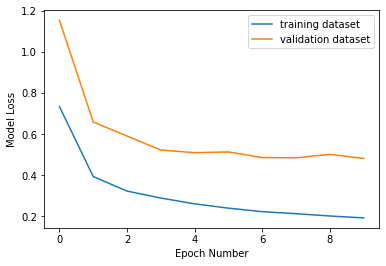

In [18]:
# Plot of the model training and validation loss
plt.xlabel('Epoch Number')
plt.ylabel('Model Loss')
plt.plot(history_100.history['loss'], label='training dataset')
plt.plot(history_100.history['val_loss'], label='validation dataset')
plt.legend()

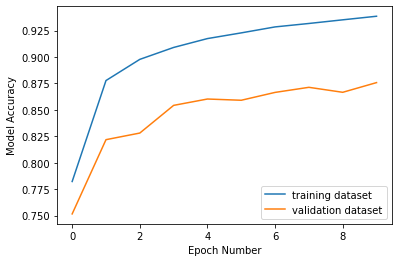

In [19]:
# Plot of the model training and validation accuracy
plt.xlabel('Epoch Number')
plt.ylabel('Model Accuracy')
plt.plot(history_100.history['accuracy'], label='training dataset')
plt.plot(history_100.history['val_accuracy'], label='validation dataset')
plt.legend()

In [33]:
# Training the model for another 5 epoch
# Fiting the model
history_5 = model.fit(
    train_generator, 
    validation_data = validation_generator,
    callbacks = callbacks,
    epochs = 5
)

Epoch 1/5
145/145 [==============================] - 4307s 30s/step - loss: 0.1816 - accuracy: 0.9408 - val_loss: 0.4580 - val_accuracy: 0.8782 - lr: 0.0010
Epoch 2/5
145/145 [==============================] - 4384s 30s/step - loss: 0.1711 - accuracy: 0.9444 - val_loss: 0.4711 - val_accuracy: 0.8791 - lr: 0.0010
Epoch 3/5
145/145 [==============================] - 4367s 30s/step - loss: 0.1687 - accuracy: 0.9444 - val_loss: 0.4942 - val_accuracy: 0.8737 - lr: 0.0010
Epoch 4/5
145/145 [==============================] - 4394s 30s/step - loss: 0.1657 - accuracy: 0.9458 - val_loss: 0.4776 - val_accuracy: 0.8739 - lr: 0.0010
Epoch 5/5
145/145 [==============================] - 4336s 30s/step - loss: 0.1558 - accuracy: 0.9489 - val_loss: 0.4878 - val_accuracy: 0.8754 - lr: 0.0010


In [34]:
# Saving the model 
model.save('sign_lang_detect_inceptv3_model_segmented_large_dataset_plus5.h5', save_format = 'h5')

In [36]:
# Plotting new training and validation data after new epoch training
losses = history_100.history['loss'] + history_5.history["loss"]
val_losses = history_100.history['val_loss'] + history_5.history["val_loss"]

accuracy = history_100.history['accuracy'] + history_5.history["accuracy"]
val_accuracy = history_100.history['val_accuracy'] + history_5.history["val_accuracy"]


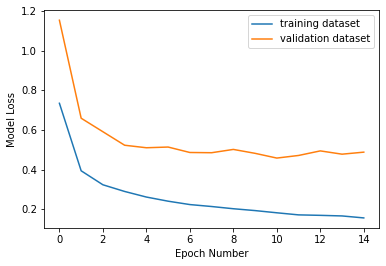

In [37]:
# Plot of the model training and validation loss
plt.xlabel('Epoch Number')
plt.ylabel('Model Loss')
plt.plot(losses, label='training dataset')
plt.plot(val_losses, label='validation dataset')
plt.legend()

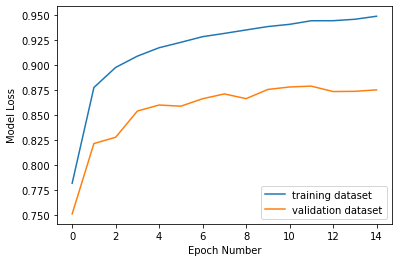

In [38]:
# Plot of the model training and validation accuracy
plt.xlabel('Epoch Number')
plt.ylabel('Model Loss')
plt.plot(accuracy, label='training dataset')
plt.plot(val_accuracy, label='validation dataset')
plt.legend()

#### Testing the model on unseen images

In [20]:
# Importing necessary libraries
from tensorflow.keras.preprocessing import image as Image
import numpy as np
from keras.models import load_model
import os
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

In [61]:
# Function to segment images using MediaPipe
def mp_segment(img_path, IMAGE_FILES, new_files_location):
    # Detect hand landmarks in images
    with mp_hands.Hands(
        static_image_mode=True,
        # Detecting one hand only
        max_num_hands=1,
        min_detection_confidence=0.5) as hands:
            for idx, file in enumerate(IMAGE_FILES):
                # Read an image, flip it around y-axis for correct handedness
                image = cv2.flip(cv2.imread(img_path + "/" + file), 1)
                # Convert the BGR image to RGB before processing.
                results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

                # Print handedness and draw hand landmarks on the background image.
                print('Handedness:', results.multi_handedness)
                if not results.multi_hand_landmarks:
                    continue
                # Image dimensions
                image_height, image_width, image_channel = image.shape
                target_size = (image_height, image_width)
                annotated_image = cv2.resize(background_img.copy(), target_size)

                for hand_landmarks in results.multi_hand_landmarks:
                    print('hand_landmarks:', hand_landmarks)
                    
                    mp_drawing.draw_landmarks(
                        annotated_image,
                        hand_landmarks,
                        mp_hands.HAND_CONNECTIONS,
                        mp_drawing_styles.get_default_hand_landmarks_style(),
                        mp_drawing_styles.get_default_hand_connections_style()
                    )
                # Save the processed image
                cv2.imwrite(new_files_location + "/" + file, cv2.flip(annotated_image, 1))

                # Draw hand world landmarks.
                if not results.multi_hand_world_landmarks:
                    continue
                for hand_world_landmarks in results.multi_hand_world_landmarks:
                    mp_drawing.plot_landmarks(
                        hand_world_landmarks, mp_hands.HAND_CONNECTIONS, azimuth=5
                    )

In [62]:
# Segment testing data

# Test data location
test_data_path = "datasets/asl_test_dataset"
# Get the test images 
test_images = os.listdir(test_data_path)

# Location of the new processed test data
new_files_location = "datasets/asl_processed_test_dataset"
# Creating the test data directory
try: 
    os.mkdir(new_files_location) 
except OSError as error: 
    print(error)



In [ ]:
# Processing the test data
mp_segment(test_data_path, test_images, new_files_location)

In [45]:
# Function to predict an image
def prediction(image_data, model):
    # Resize the image
    img_arr = Image.smart_resize(image_data, target_size)

    processed_old = np.expand_dims(img_arr, axis=0)
    processed = processed_old / 255.

    # Predicting the image
    predicted_class = model.predict(processed)

    # Get the index of the prediction
    index = np.argmax(predicted_class)

    # Convert list of predictions to float at 2 decimal places
    predicted_probabilities = list(
        map('{:.2f}'.format,
        predicted_class[0]*100)
    )

    # Show only predictions with greather than 50% probability
    if (float(predicted_probabilities[index]) > 80):
        prediction_result = "Prediction-Confident : {} \n Probability : {}%".format(str(asl_data.class_names[index]).title(), predicted_probabilities[index])
        plt.title(prediction_result, 
            size=18, 
            color='green'
        )
        plt.imshow(image_data)
        #print(predicted_class)
    elif (float(predicted_probabilities[index]) < 81  and float(predicted_probabilities[index]) > 50):
        prediction_result = "Prediction-Moderate : {} \n Probability : {}%".format(str(asl_data.class_names[index]).title(), predicted_probabilities[index])
        plt.title(prediction_result, 
            size=18, 
            color='blue'
        )
        plt.imshow(image_data)
    elif(float(predicted_probabilities[index]) < 51  and float(predicted_probabilities[index]) > 30):
        prediction_result = "Prediction-Low Confidence : {} \n Probability : {}%".format(str(asl_data.class_names[index]).title(), predicted_probabilities[index])
        plt.title(prediction_result, 
            size=18, 
            color='red'
        )
        plt.imshow(image_data)
    else:
        prediction_result = "hum... I didn't quite get that, please try again"
        plt.title(prediction_result, 
            size=18, 
            color='red'
        )
        plt.imshow(image_data)

    return prediction_result

In [31]:
# import necessary modules
import glob, random

# Select random unseen test image
file_path_type = "datasets/asl_processed_test_dataset/*.jpeg"
def rand_img():
    img = glob.glob(file_path_type)
    rand_img = random.choice(img)
    rand_img = Image.load_img(rand_img, target_size = target_size)
    return rand_img

In [13]:
# Load the model for prediction
model = load_model("sign_lang_detect_inceptv3_model_segmented_large_dataset_plus5.h5")

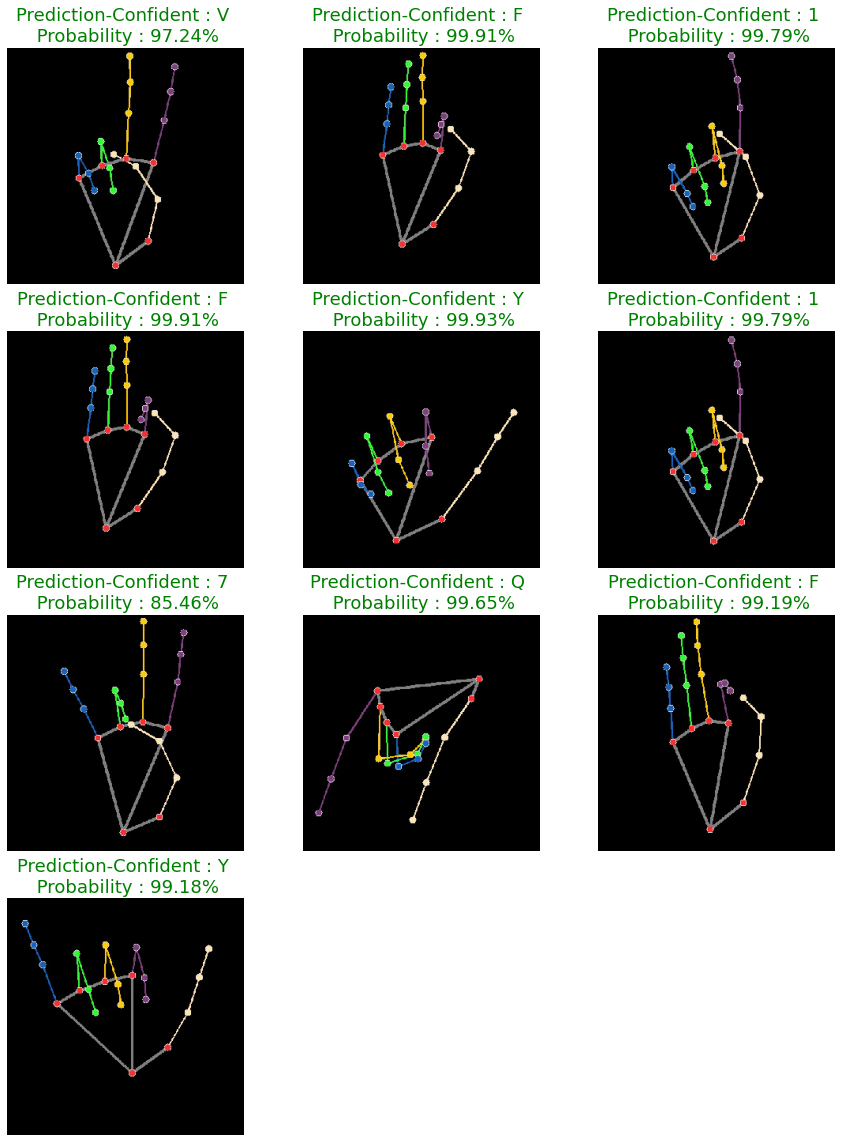

In [47]:
# Plot 10 predictions
plt.figure(figsize=(15, 20))
for x in range(10):
    ax = plt.subplot(4, 3, x + 1)
    prediction(rand_img(), model)
    plt.axis("off")

## The Model in Action

Next, we build a real-time system to detect hand signs. Again, we will have a live feed from the video cam, and at every frame that catches a hand, the model will predict it.

First, we use the Mediapipe hand to detect hand signs, then use the model to predict them. After the model successfully predicts the hand sign, we will overlay the prediction over the camera feed to achieve real-time detection.

Reference: https://google.github.io/mediapipe/solutions/hands.html

In [40]:
import cv2
import mediapipe as mp
from keras.models import load_model
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands


In [53]:
# Image size
target_size = (300, 300)
# Background image to draw hand landmarks on
background_img = cv2.imread("mod_background_black.jpg")
# Load the model for prediction
model = load_model("sign_lang_detect_inceptv3_model_segmented_large_dataset_plus5.h5")

In [43]:
# Dimensions for detection region
detect_region_top = 50
detect_region_bottom = 450
detect_region_left = 450
detect_region_right = 50

In [50]:
from PIL import Image as im

In [ ]:
img_png = im.open("background_black.png")

# Save the image to jpg
img_png.save("mod_background_black.jpg")

In [61]:
prev_annotated_image = cv2.resize(background_img.copy(), (400, 400))
prev_annotated_image.size

prev_hand_landmarks = None

In [ ]:
# Webcam input
cap = cv2.VideoCapture(0)

with mp_hands.Hands(
    model_complexity=1,
    min_detection_confidence=0.8,
    max_num_hands=1,
    min_tracking_confidence=0.9) as hands:
    while cap.isOpened():
        success, frame = cap.read()
        # Flip the image horizontally for a selfie-view display.
        #frame = cv2.flip(frame, 1)
        if not success:
            print("Ignoring empty camera frame.")
            continue
        # To improve performance, optionally mark the image as not writeable to
        # pass by reference.
        frame.flags.writeable = False
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image = frame[detect_region_top:detect_region_bottom, 
            detect_region_right:detect_region_left]
        results = hands.process(image)

        # Drawing the detection region on frame copy
        cv2.rectangle(frame, (detect_region_left, detect_region_top), 
            (detect_region_right, detect_region_bottom), (255,128,0), 3)
        
        # Draw the hand annotations on the background image.
        image.flags.writeable = True
        #image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        annotated_image = cv2.resize(background_img.copy(), (400, 400))
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                
                if prev_hand_landmarks != hand_landmarks:
                    mp_drawing.draw_landmarks(
                        image,
                        hand_landmarks,
                        mp_hands.HAND_CONNECTIONS,
                        mp_drawing_styles.get_default_hand_landmarks_style(),
                        mp_drawing_styles.get_default_hand_connections_style()
                    )
                    mp_drawing.draw_landmarks(
                        annotated_image,
                        hand_landmarks,
                        mp_hands.HAND_CONNECTIONS,
                        mp_drawing_styles.get_default_hand_landmarks_style(),
                        mp_drawing_styles.get_default_hand_connections_style()
                    )

                    prev_hand_landmarks = hand_landmarks
            
            # Predict the annotated image
            predicted_results = prediction(annotated_image, model)
            prev_annotated_image = annotated_image
            # Flip the image horizontally for a selfie-view display.
            frame = cv2.flip(frame, 1)
            # Display the prediction on the feed
            cv2.putText(frame, predicted_results, (150, 430), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)
            # Show the camera feed
            cv2.imshow('ASL Hands Detection with Mediapipe', frame)

            cv2.imshow("predicted hand sign", annotated_image)
        else:
            predicted_results = "No hand detected"
            # Flip the image horizontally for a selfie-view display.
            frame = cv2.flip(frame, 1)
            # Display the prediction on the feed
            cv2.putText(frame, predicted_results, (150, 430), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)
            # Show the camera feed
            cv2.imshow('ASL Hands Detection with Mediapipe', frame)

        if cv2.waitKey(5) & 0xFF == 27:
            break
cv2.destroyAllWindows()
cap.release()